In [2]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import statsmodels
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import integrate

In [2]:
#Here we define the disparity filter for backboning our future networks.
def disparity_filter(G, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    if nx.is_directed(G): #directed case
        N = nx.DiGraph()
        for u in G:
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in G.successors(u))
                for v in G.successors(u):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.4f' % alpha_ij_out))
            elif k_out == 1 and G.in_degree(G.successors(u)[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = G.successors(u)[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in G.predecessors(u))
                for v in G.predecessors(u):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.4f' % alpha_ij_in))
        return N
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B


Exposure part
===

In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist 
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

In [4]:
#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


In [5]:
len(chem_gene_cleaned)

9887

In [6]:
#Let's define the background for future hypergeometric test (the total number of genes in our dataset)
tot_gene=len(set(tot_gene_list))

In [7]:
#This function performs a fisher test for the exposures
def overlap_set_exposures(setA, setB,tot_gene):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M=  tot_gene #total number of genes
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

In [8]:
def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

In [ ]:
#Here we calculate all the statistical significance of the overlap between all possible exposures with a 
#Fisher test
combination_list=list(it.combinations(chem_gene_cleaned.keys(),2))
exposure_graph_fisher={}
for i in combination_list:
    fisher_test=overlap_set_exposures(chem_gene_cleaned[i[0]],chem_gene_cleaned[i[1]],tot_gene)
    exposure_graph_fisher[i]=float(fisher_test)

In [ ]:
#Let's write the results in the intermidiate folder
with open('intermidiate/exposure_graph_fisher.pickle', 'wb') as handle:
    pk.dump(exposure_graph_fisher, handle, protocol=pk.HIGHEST_PROTOCOL)

In [61]:
import pickle as pk
#Let's import the precomputed analysis
with open('intermediate/exposure_graph_fisher.pickle', 'rb') as handle:
    exposure_graph_fisher = pk.load(handle)

In [62]:
len(exposure_graph_fisher)

48871441

In [12]:
9887*9886/2

48871441.0

In [ ]:
#We are going to test several combinations of alpha significance value in the Benjamin-Hocberg correction
#and alpha values of the disparity filter
#We will run this cell on the cluster and import the results (the code can be found here below and in the file EEN_cutoff_calibration)


#I want to check here how it will changes the number of nodes and the number of edges, changing the threshold
#This function allows us to correct for multiple hypothesis
from statsmodels.sandbox.stats.multicomp import multipletests
import math
def fdr_adjustment(list_of_pvals):
    return multipletests(list_of_pvals,method='fdr_bh')[1] #the benjamin hochberg method is used

fdr_threshold=[0.05,0.01,0.001,0.0001,0.00001]   #different alpha threshold
alpha_backbone_threshold=[0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.01]   #different alpha threshold
exp_keys_list=list(exposure_graph_fisher.keys())
exp_pvalues_list=list(exposure_graph_fisher.values())
adj_pvals=fdr_adjustment(exp_pvalues_list)
exp_graph_fisher_adjusted={} #here we obtain a dictionary of pairs with adjusted p-values
for el in range(len(exp_keys_list)):
    exp_graph_fisher_adjusted[exp_keys_list[el]]=adj_pvals[el]
comb_threshold_dict_nodes={}
comb_threshold_dict_edges={}
for alpha_t in fdr_threshold:
    exp_graph_ji_significant={}  #here, we select only the statistically significant
    for chem,fdr in exp_graph_fisher_adjusted.items():
        if float(fdr)<alpha_t:
            ji= overlap_jaccard(chem_gene_cleaned[chem[0]],chem_gene_cleaned[chem[1]])      #we are computing the odds ratio
            exp_graph_ji_significant[chem]=ji                                                     #and used as an edge weight
        else:
            pass
    weighted_exp_graph_significant=nx.Graph()
    for exp,ji_score in exp_graph_ji_significant.items():
        weighted_exp_graph_significant.add_edge(*exp)
        weighted_exp_graph_significant[exp[0]][exp[1]]['weight']=ji_score
    weighted_exp_graph_significant_dif = disparity_filter(weighted_exp_graph_significant)
    for alpha_b in alpha_backbone_threshold:
        backbone_exp_graph_significant = nx.Graph([(u, v, d) for u, v, d in weighted_exp_graph_significant_dif.edges(data=True) if d['alpha'] < alpha_b])   #let's apply the backboning threshold approach
        comb_threshold_dict_nodes["fdr_"+str(alpha_t),"backbone_"+str(alpha_b)]=backbone_exp_graph_significant.number_of_nodes()
        comb_threshold_dict_edges["fdr_"+str(alpha_t),"backbone_"+str(alpha_b)]=backbone_exp_graph_significant.number_of_edges()



In [ ]:
with open('intermidiate/comb_threshold_dict_nodes_EEN_ji.pickle', 'wb') as handle:
    pk.dump(comb_threshold_dict_nodes, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('intermidiate/comb_threshold_dict_edges_EEN_ji.pickle', 'wb') as handle:
    pk.dump(comb_threshold_dict_edges, handle, protocol=pk.HIGHEST_PROTOCOL)

In [24]:

with open('intermediate/comb_threshold_dict_nodes_EEN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_nodes_EEN_ji = pk.load(handle)
    
with open('intermediate/comb_threshold_dict_edges_EEN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_edges_EEN_ji = pk.load(handle)

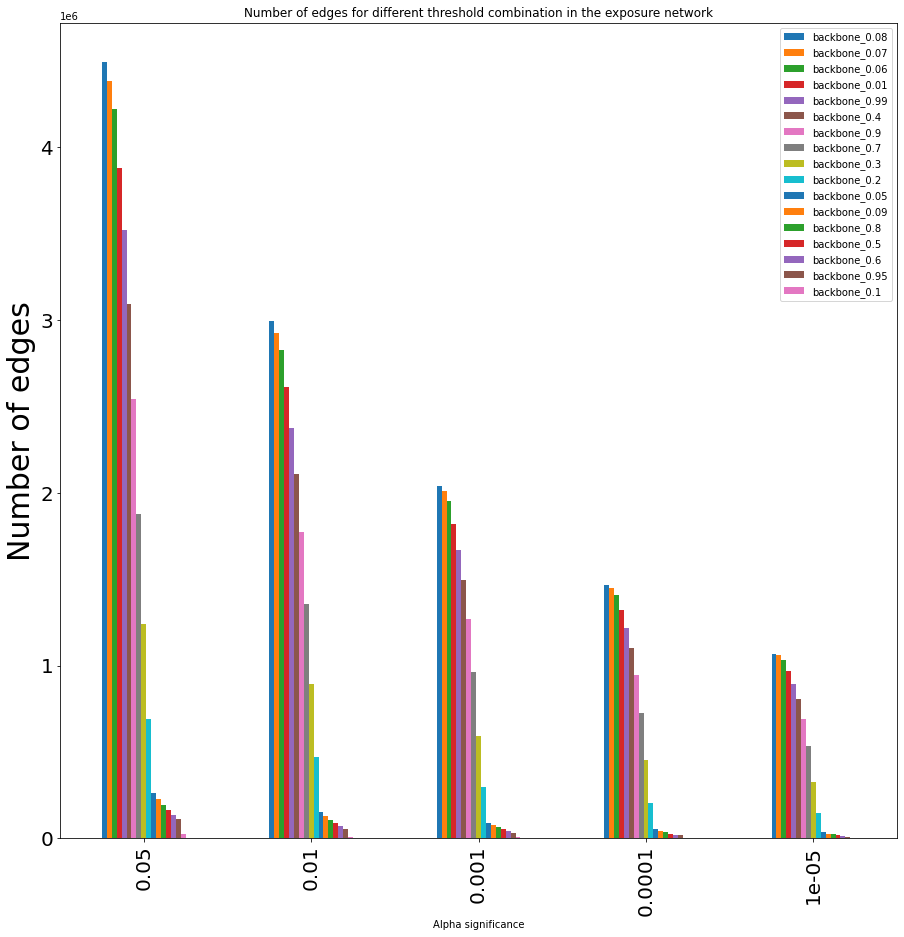

In [41]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_edges_EEN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_edges_EEN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_edges_EEN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of edges for different threshold combination in the exposure network')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of edges',fontsize=30)
#plt.savefig('output/Figures/SF1B_v01.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

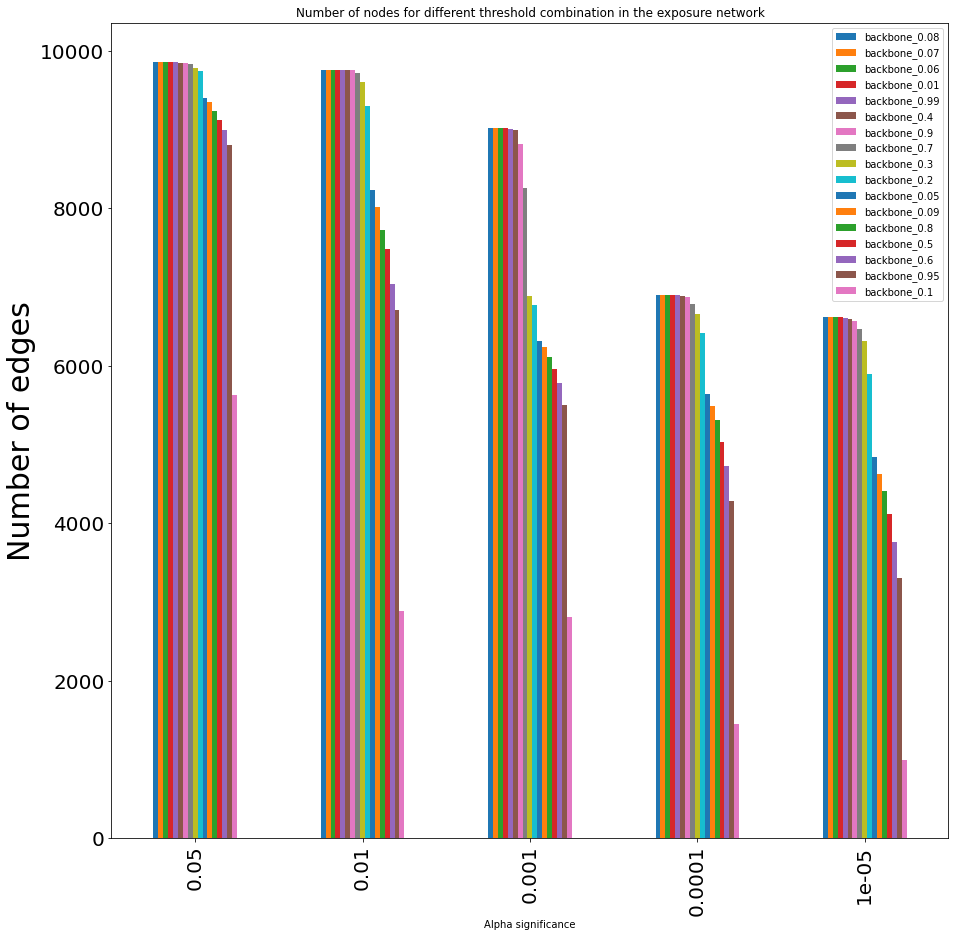

In [52]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_nodes_EEN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_nodes_EEN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_nodes_EEN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of nodes for different threshold combination in the exposure network')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of edges',fontsize=30)
#plt.savefig('output/Figures/SF1A_v01.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

In [72]:
for k,v in comb_threshold_dict_edges_EEN_ji.items():
    if v<1000000 and comb_threshold_dict_nodes_EEN_ji[k]>9000:
        print(k,comb_threshold_dict_nodes_EEN_ji[k],v)

('fdr_0.05', 'backbone_0.2') 9741 692348
('fdr_0.05', 'backbone_0.1') 9401 261524
('fdr_0.05', 'backbone_0.09') 9346 229629
('fdr_0.05', 'backbone_0.08') 9233 194222
('fdr_0.05', 'backbone_0.07') 9122 164694
('fdr_0.01', 'backbone_0.3') 9606 892900
('fdr_0.01', 'backbone_0.2') 9302 468817


In [75]:
#Based on these results we have decided to go for a combination of 
#FDR=0.01 and backboning-alpha=0.2, resulting in the following number of false positives

def fdr_adjustment_and_count(list_of_pvals, alpha=0.05):
    adjusted_pvals = multipletests(list_of_pvals, method='fdr_bh')[1]  # the Benjamini-Hochberg method is used
    discoveries = np.sum(adjusted_pvals < alpha)  # count the number of discoveries
    expected_false_positives = alpha * discoveries  # calculate the expected number of false positives
    return adjusted_pvals, expected_false_positives

print("The number of estimated false positives in the EEN is %s"%fdr_adjustment_and_count(list(exposure_graph_fisher.values()),alpha=0.01)[1])


The number of estimated false positives in the EEN is 29981.940000000002


In [10]:
from statsmodels.sandbox.stats.multicomp import multipletests
import math
def fdr_adjustment(list_of_pvals):
    return multipletests(list_of_pvals,method='fdr_bh')[1] #the benjamin hochberg method is used

exp_keys_list=list(exposure_graph_fisher.keys())
exp_pvalues_list=list(exposure_graph_fisher.values())
adj_pvals=fdr_adjustment(exp_pvalues_list)
exp_graph_fisher_adjusted={} #here we obtain a dictionary of pairs with adjusted p-values
for el in range(len(exp_keys_list)):
    exp_graph_fisher_adjusted[exp_keys_list[el]]=adj_pvals[el]

exp_graph_ji_significant={}  #here, we select only the statistically significant
for chem,fdr in exp_graph_fisher_adjusted.items():
    if float(fdr)<0.01:
        ji= overlap_jaccard(chem_gene_cleaned[chem[0]],chem_gene_cleaned[chem[1]])      #we are computing the odds ratio
        exp_graph_ji_significant[chem]=ji                                                     #and used as an edge weight
    else:
        pass
weighted_exp_graph_significant=nx.Graph()
for exp,ji_score in exp_graph_ji_significant.items():
    weighted_exp_graph_significant.add_edge(*exp)
    weighted_exp_graph_significant[exp[0]][exp[1]]['weight']=ji_score
weighted_exp_graph_significant_dif = disparity_filter(weighted_exp_graph_significant)
backbone_exp_graph_significant = nx.Graph([(u, v, d) for u, v, d in weighted_exp_graph_significant_dif.edges(data=True) if d['alpha'] < 0.2])   #let's apply the backboning threshold approach

print(backbone_exp_graph_significant.number_of_nodes()) #Number of nodes
print(backbone_exp_graph_significant.number_of_edges()) #Number of edges

9302
468817


In [11]:
final_backbone_exp_graph_significant_combo_df = nx.to_pandas_edgelist(backbone_exp_graph_significant,'Exp A', 'Exp B')
final_backbone_exp_graph_significant_combo_df.to_csv('output/final_backbone_exp_graph_significant_combo_ji_df.tsv', sep = '\t')


In [12]:
#Let's import the final EEN
final_backbone_exp_graph_significant_combo_df = pd.read_csv("output/final_backbone_exp_graph_significant_combo_ji_df.tsv", sep="\t",index_col=0)
backbone_ss_exposure_network = nx.from_pandas_edgelist(final_backbone_exp_graph_significant_combo_df, 'Exp A', 'Exp B')


In [6]:
#Extract degrees from the EEN
degrees_EEN = [x[1] for x in  nx.degree(backbone_ss_exposure_network)]
#Get the unique PPI degree steps

degrees_EEN_unique = list(set(degrees_EEN))
degrees_EEN_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesEEN = []

#Normal distribution (i.e. P(k = x))
degreeDistributionEEN = []
degreeDistributionEENcount = []

for degree in degrees_EEN_unique:
    degreesEEN.append(degree)
    degreeDistributionEEN.append(degrees_EEN.count(degree)/float(len(degrees_EEN)))
    degreeDistributionEENcount.append(degrees_EEN.count(degree))


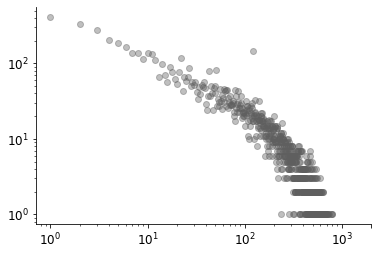

In [18]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

#Let's plot the Degree distribution of the EEN
fig1, ax1 = plt.subplots()
plt.scatter(degreesEEN, degreeDistributionEENcount, c='#5F5F5F', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000, 2000])

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)

#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
#plt.savefig('output/Figures/Fig1D.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1E

plt.show()
plt.close()

In [13]:
backbone_ss_exposure_network_degree_sort=dict(sorted(dict(nx.degree(backbone_ss_exposure_network)).items(), key=lambda item: item[1], reverse=True))



In [13]:
top_10_exp=list(backbone_ss_exposure_network_degree_sort.keys())[:10]
gene_top10=[]
for chem in top_10_exp:
    for gene in chem_gene_cleaned[chem]:
        gene_top10.append(gene)
    
gene_top10_dict_count=Counter(gene_top10).most_common()

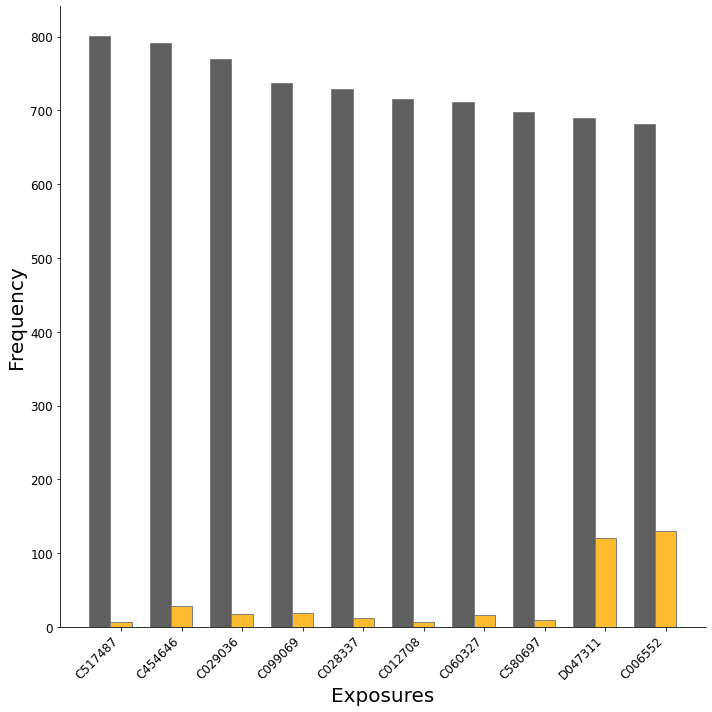

In [22]:

degree_list=[backbone_ss_exposure_network_degree_sort[chem] for chem in top_10_exp]
gene_list=[len(chem_gene_cleaned[chem]) for chem in top_10_exp]

# define the width of bars
barWidth = 0.35 

fig1, ax1 = plt.subplots(figsize=(10, 10))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

r1 = np.arange(len(degree_list))    # position for degree bars
r2 = [x + barWidth for x in r1]  # position for gene bars

plt.bar(r1, degree_list, color='#5F5F5F', width=barWidth, edgecolor='grey')  # degree bars
plt.bar(r2, gene_list, color='#FDBB30', width=barWidth, edgecolor='grey')  # gene bars

# adding labels
ax1.set_xlabel('Exposures', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
plt.xticks([r + barWidth for r in range(len(degree_list))], top_10_exp, rotation=45, ha='right', fontsize=12)

ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.yticks(fontsize=12)
#plt.savefig('output/Figures/Fig1E.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J

plt.tight_layout()
plt.show()


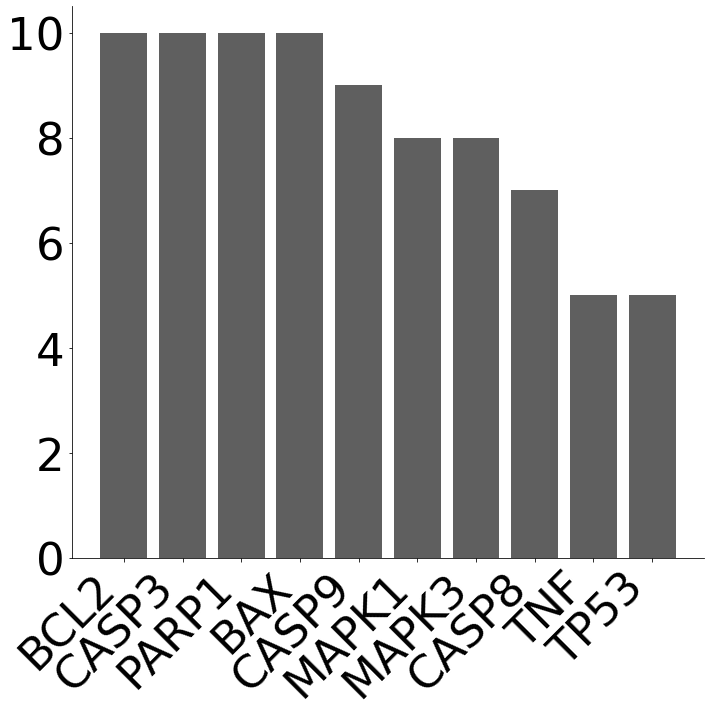

In [43]:
#Let's plot it, color them by their chemical class of belonging 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(figsize=(10, 10))

new_label=[g[0] for g in gene_top10_dict_count[:10]]
frequency=[g[1] for g in gene_top10_dict_count[:10]]


x = np.arange(10)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
plt.bar(x, frequency,color='#5F5F5F')
#plt.title('Frequency of exposures rank by their degree',fontsize=32)
#plt.ylabel('Frequency',fontsize=20)
#plt.xlabel('Exposures',fontsize=20)
#plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
#plt.yticks([],fontsize=45,rotation=45,ha='right')
plt.yticks(fontsize=45)
plt.tight_layout()

    
#plt.savefig('output/Figures/SF3A.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()

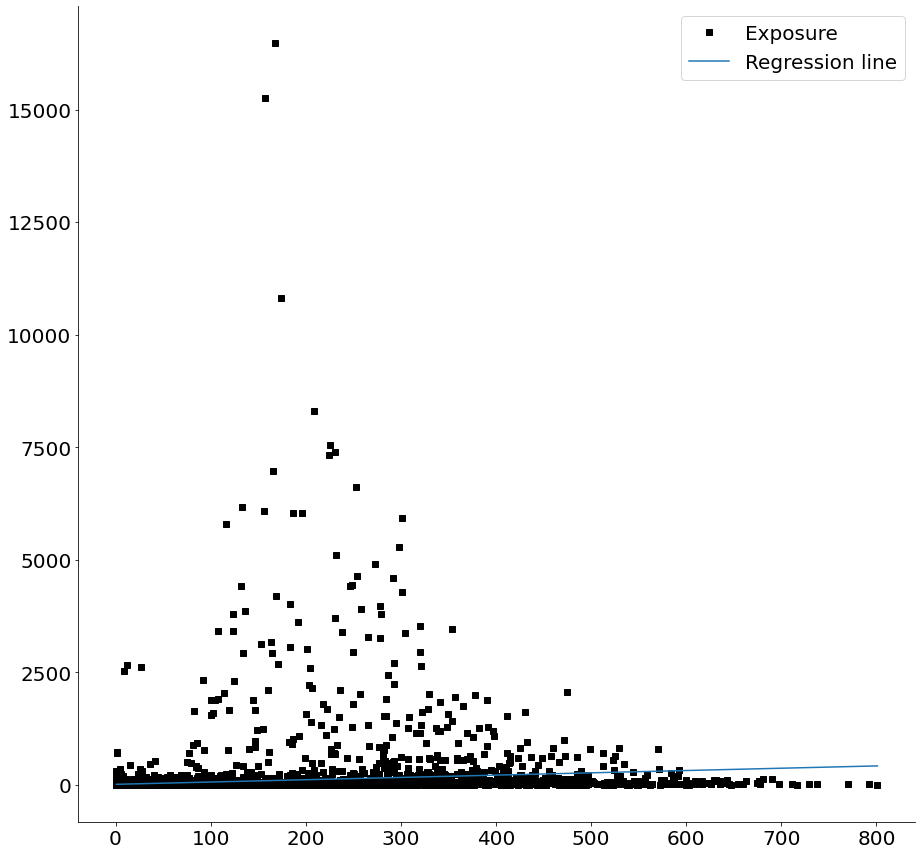

In [27]:
import scipy
from matplotlib.pyplot import figure
from scipy import stats

#Let's check whether there is a correlation between the number of perturbed genes and the number of connections in the EEN
deg_list=[]
len_genelist=[]
for chem,deg in backbone_exp_graph_significant_sort.items():
    deg_list.append(deg)
    len_genelist.append(len(chem_gene_cleaned[chem]))
    
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(deg_list, len_genelist)

ax.plot(deg_list,len_genelist, linewidth=0, marker='s',c='k', label='Exposure')
y=[]
for i in deg_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(deg_list, y, label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 

ax.legend(facecolor='white',fontsize=20)
plt.show()

In [28]:
print(scipy.stats.pearsonr(deg_list,len_genelist))  # Pearson's r
print(scipy.stats.spearmanr(deg_list,len_genelist)) # Spearman's rho

PearsonRResult(statistic=0.1373485062973162, pvalue=2.075103895313211e-40)
SpearmanrResult(correlation=0.5594625798057589, pvalue=0.0)


In [117]:
chem_list_1=[]
chem_list_2=[]
chem_list_3=[]
chem_list_4=[]
chem_list_5=[]
chem_list_6=[]
chem_list_7=[]
chem_list_8=[]
chem_list_9=[]
chem_list_10=[]

deg_max=max(list(backbone_ss_exposure_network_degree_sort.values()))
for chem,deg in backbone_ss_exposure_network_degree_sort.items():
    if deg<0.1*deg_max:
        chem_list_1.append(len(chem_gene_cleaned[chem]))
    elif deg>0.1*deg_max and deg<2*0.1*deg_max:
        chem_list_2.append(len(chem_gene_cleaned[chem]))
    elif deg>2*0.1*deg_max and deg<3*0.1*deg_max:
        chem_list_3.append(len(chem_gene_cleaned[chem]))
    elif deg>3*0.1*deg_max and deg<4*0.1*deg_max:
        chem_list_4.append(len(chem_gene_cleaned[chem]))
    elif deg>4*0.1*deg_max and deg<5*0.1*deg_max:
        chem_list_5.append(len(chem_gene_cleaned[chem]))
    elif deg>5*0.1*deg_max and deg<6*0.1*deg_max:
        chem_list_6.append(len(chem_gene_cleaned[chem]))
    elif deg>6*0.1*deg_max and deg<7*0.1*deg_max:
        chem_list_7.append(len(chem_gene_cleaned[chem]))
    elif deg>7*0.1*deg_max and deg<8*0.1*deg_max:
        chem_list_8.append(len(chem_gene_cleaned[chem]))
    elif deg>8*0.1*deg_max and deg<9*0.1*deg_max:
        chem_list_9.append(len(chem_gene_cleaned[chem]))
    else:
        chem_list_10.append(len(chem_gene_cleaned[chem]))
        

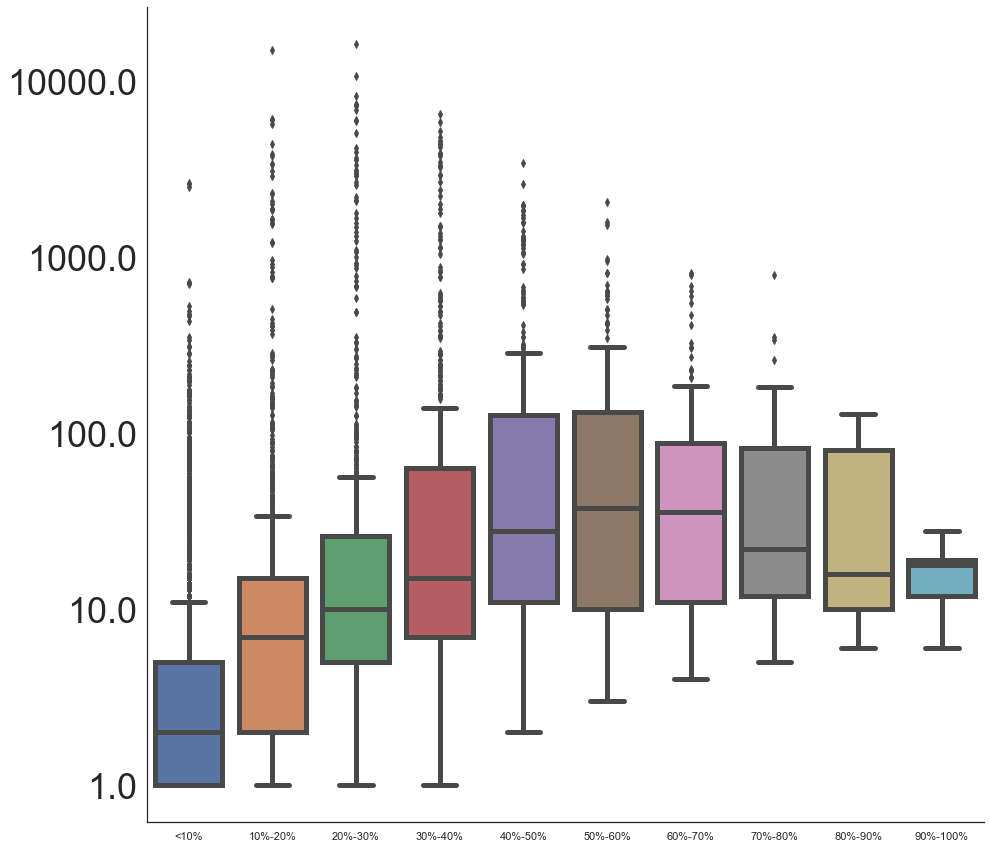

In [150]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community


column_names = ["Degree", "# Genes"]

chem_list_tot=[]
group_list=[]
for i in chem_list_1:
    chem_list_tot.append(i)
    group_list.append("<10%")
    
for i in chem_list_2:
    chem_list_tot.append(i)
    group_list.append("10%-20%")

for i in chem_list_3:
    chem_list_tot.append(i)
    group_list.append("20%-30%")
    
for i in chem_list_4:
    chem_list_tot.append(i)
    group_list.append("30%-40%")
    
for i in chem_list_5:
    chem_list_tot.append(i)
    group_list.append("40%-50%")

for i in chem_list_6:
    chem_list_tot.append(i)
    group_list.append("50%-60%")

for i in chem_list_7:
    chem_list_tot.append(i)
    group_list.append("60%-70%")
    
for i in chem_list_8:
    chem_list_tot.append(i)
    group_list.append("70%-80%")
    
for i in chem_list_9:
    chem_list_tot.append(i)
    group_list.append("80%-90%")

for i in chem_list_10:
    chem_list_tot.append(i)
    group_list.append("90%-100%")
    
    
chem_degree_df = pd.DataFrame(columns = column_names)
chem_degree_df["# Genes"]=chem_list_tot
chem_degree_df["Degree"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.boxplot(x=chem_degree_df["Degree"], y=chem_degree_df["# Genes"], linewidth=5)
#ax = sns.barplot(x="louvain Iteration", y="z-score lcc", data=EEN_louvain_com_df,
#                 palette="Blues_d")
g.set_yscale("log")

ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
#plt.savefig('output/Figures/SF2A.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

Gene Part
===

In [3]:
#Let's build also the vice-versa: the gene-chem dictionary
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])

In [4]:
#Let's remove the elements which have 0 exposures associated with
gene_chem_cleaned = {}
tot_exp_list=[]
for k,v in gene_chem.items():
    if len(v)>0:
        gene_chem_cleaned[k]=v
        for exp in v:
            tot_exp_list.append(exp)
    else:
        pass
gene_chem_cleaned = {k: gene_chem_cleaned[k] for k in gene_chem_cleaned if type(k)==str}

In [5]:
len(gene_chem_cleaned)

25579

In [6]:
gene_chem_cleaned_len = {}
for gene,explist in gene_chem_cleaned.items():
    gene_chem_cleaned_len[gene]=len(explist)

In [7]:
with open('intermediate/gene_chem_cleaned_len.pickle', 'wb') as handle:
    pk.dump(gene_chem_cleaned_len, handle, protocol=pk.HIGHEST_PROTOCOL)

In [98]:
#this is the total number of exposures, that would mean the background for our Fisher test
tot_exp=len(set(tot_exp_list))

In [99]:
def overlap_set_genes(setA, setB,tot_exp):
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= tot_exp #total number of exposures
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

In [ ]:
#Here, we have calculated the fisher test based on the jaccard index
gene_graph_fisher={}
for i in it.combinations(gene_chem_cleaned.keys(),2):
    fisher_test=overlap_set_genes(gene_chem_cleaned[i[0]],gene_chem_cleaned[i[1]],tot_exp)
    gene_graph_fisher[i]=float(fisher_test)

In [ ]:
with open('intermediate/gene_graph_fisher.pickle', 'wb') as handle:
    pk.dump(gene_graph_fisher, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
with open('intermediate/gene_graph_fisher.pickle', 'rb') as handle:
    gene_graph_fisher = pk.load(handle)

In [ ]:
#I want to check here how it will changes the number of nodes and the number of edges, changing the threshold
#This cell is run in the cluster under the script GGN_cutoff_calibration.py

fdr_threshold=[0.05,0.01,0.001,0.0001,0.00001]   #different alpha threshold
alpha_backbone_threshold=[0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.01]   #different alpha threshold
gene_keys_list=list(gene_graph_fisher.keys())
gene_pvalues_list=list(gene_graph_fisher.values())
adj_pvals=fdr_adjustment(gene_pvalues_list)
gene_graph_fisher_adjusted={} #here we obtain a dictionary of pairs with adjusted p-values
for el in range(len(gene_keys_list)):
    gene_graph_fisher_adjusted[gene_keys_list[el]]=adj_pvals[el]
comb_threshold_dict_nodes={}
comb_threshold_dict_edges={}
for alpha_t in fdr_threshold:
    gene_graph_ji_significant={}  #here, we select only the statistically significant
    for gene_p,fdr in gene_graph_fisher_adjusted.items():
        if float(fdr)<alpha_t:
            ji= overlap_jaccard(gene_chem_cleaned[gene_p[0]],gene_chem_cleaned[gene_p[1]])      #we are computing the odds ratio
            gene_graph_ji_significant[gene_p]=ji                                                     #and used as an edge weight
        else:
            pass
    weighted_gene_graph_significant=nx.Graph()
    for gene_p,ji_score in gene_graph_ji_significant.items():
        weighted_gene_graph_significant.add_edge(*gene_p)
        weighted_gene_graph_significant[gene_p[0]][gene_p[1]]['weight']=ji_score
    weighted_gene_graph_significant_dif = disparity_filter(weighted_gene_graph_significant)
    for alpha_b in alpha_backbone_threshold:
        backbone_gene_graph_significant = nx.Graph([(u, v, d) for u, v, d in weighted_gene_graph_significant_dif.edges(data=True) if d['alpha'] < alpha_b])   #let's apply the backboning threshold approach
        comb_threshold_dict_nodes["fdr_"+str(alpha_t),"backbone_"+str(alpha_b)]=backbone_gene_graph_significant.number_of_nodes()
        comb_threshold_dict_edges["fdr_"+str(alpha_t),"backbone_"+str(alpha_b)]=backbone_gene_graph_significant.number_of_edges()

#Let's write the results in the intermidiate folder
with open('intermediate/comb_threshold_dict_edges_GGN_ji.pickle', 'wb') as handle:
    pk.dump(comb_threshold_dict_edges, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('intermediate/comb_threshold_dict_nodes_GGN_ji.pickle', 'wb') as handle:
    pk.dump(comb_threshold_dict_nodes, handle, protocol=pk.HIGHEST_PROTOCOL)

In [49]:

with open('intermediate/comb_threshold_dict_nodes_GGN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_nodes_GGN_ji = pk.load(handle)
    
with open('intermediate/comb_threshold_dict_edges_GGN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_edges_GGN_ji = pk.load(handle)

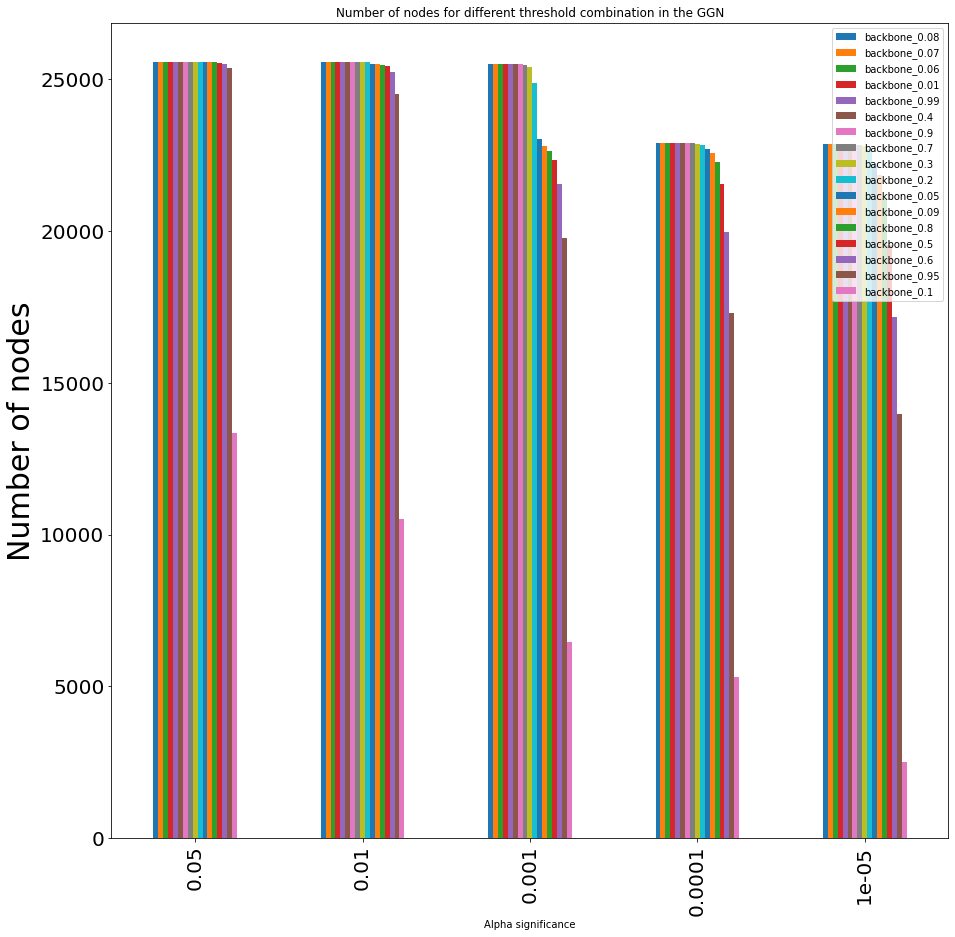

In [76]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_nodes_GGN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_nodes_GGN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_nodes_GGN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of nodes for different threshold combination in the GGN')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of nodes',fontsize=30)
#plt.savefig('output/Figures/SF1C_v01.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

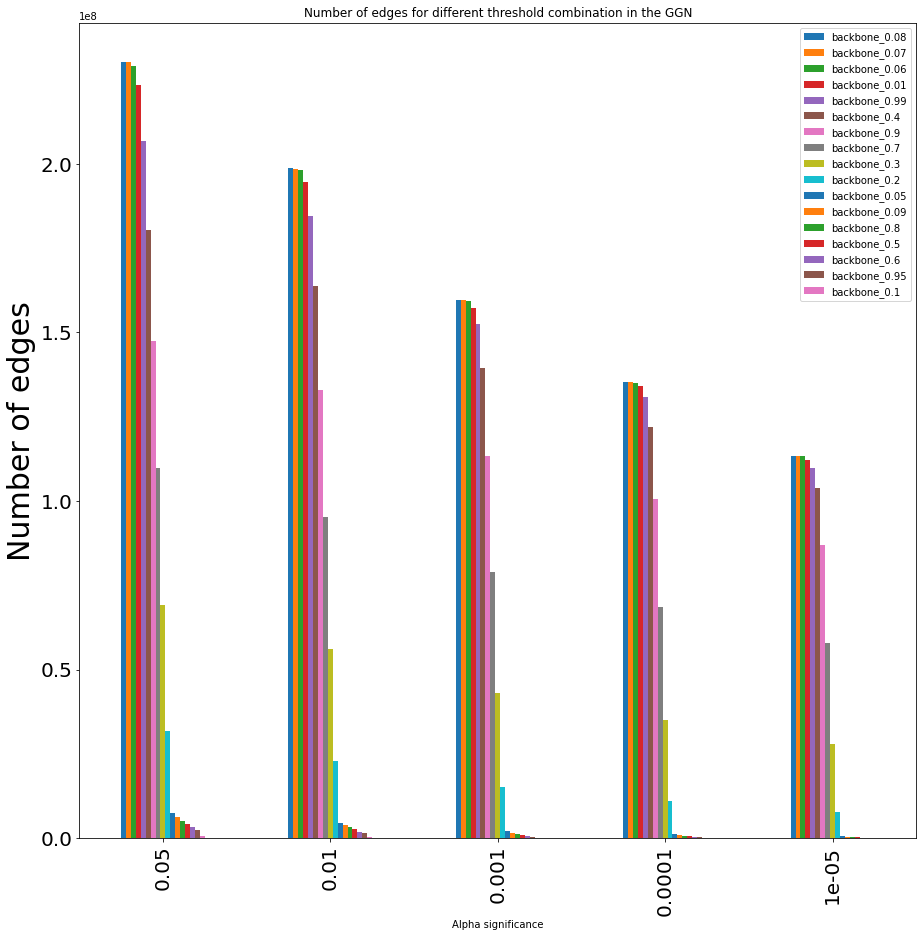

In [54]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_edges_GGN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_edges_GGN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_edges_GGN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of edges for different threshold combination in the GGN')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of edges',fontsize=30)
#plt.savefig('output/Figures/SF1D_v01.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

In [59]:
for k,v in comb_threshold_dict_edges_GGN_ji.items():
    if v<1500000 and comb_threshold_dict_nodes_GGN_ji[k]>20000:
        print(k,comb_threshold_dict_nodes_GGN_ji[k],v)

('fdr_0.001', 'backbone_0.08') 22640 1254212
('fdr_0.001', 'backbone_0.07') 22339 945399
('fdr_0.001', 'backbone_0.06') 21541 685139
('fdr_0.0001', 'backbone_0.1') 22707 1367753
('fdr_0.0001', 'backbone_0.09') 22571 1061656
('fdr_0.0001', 'backbone_0.08') 22285 808961
('fdr_0.0001', 'backbone_0.07') 21560 601322
('fdr_1e-05', 'backbone_0.1') 22201 695189
('fdr_1e-05', 'backbone_0.09') 21855 499893
('fdr_1e-05', 'backbone_0.08') 21082 359035


In [ ]:
#Based on these results we have decided to go for a combination of 
#FDR=1e-05 and backboning-alpha=0.1, resulting in the following number of false positives

def fdr_adjustment_and_count(list_of_pvals, alpha=0.05):
    adjusted_pvals = multipletests(list_of_pvals, method='fdr_bh')[1]  # the Benjamini-Hochberg method is used
    discoveries = np.sum(adjusted_pvals < alpha)  # count the number of discoveries
    expected_false_positives = alpha * discoveries  # calculate the expected number of false positives
    return adjusted_pvals, expected_false_positives

print("The number of estimated false positives in the GGN is %s"%fdr_adjustment_and_count(list(gene_graph_fisher.values()),alpha=0.00001)[1])
#The number of estimated false positives in the GGN is 1133.6523200000001
#The total number of the gene_graph_fisher is 327129831



In [ ]:
#Network creation

gene_keys_list=list(gene_graph_fisher.keys())
gene_pvalues_list=list(gene_graph_fisher.values())
gene_adj_pvals=fdr_adjustment(gene_pvalues_list)
gene_graph_fisher_adjusted={} #here we obtain a dictionary of pairs with adjusted p-values
for el in range(len(gene_keys_list)):
    gene_graph_fisher_adjusted[gene_keys_list[el]]=gene_adj_pvals[el]

gene_graph_ji_significant={}  #here, we select only the statistically significant
for gene_p,fdr in gene_graph_fisher_adjusted.items():
    if float(fdr)<0.00001:
        ji= overlap_jaccard(gene_chem_cleaned[gene_p[0]],gene_chem_cleaned[gene_p[1]])      #we are computing the odds ratio
        gene_graph_ji_significant[gene_p]=ji                                                     #and used as an edge weight
    else:
        pass
weighted_gene_graph_significant=nx.Graph()
for gene,ji_score in gene_graph_ji_significant.items():
    weighted_gene_graph_significant.add_edge(*gene)
    weighted_gene_graph_significant[gene[0]][gene[1]]['weight']=ji_score
weighted_gene_graph_significant_dif = disparity_filter(weighted_gene_graph_significant)
backbone_gene_graph_significant = nx.Graph([(u, v, d) for u, v, d in weighted_gene_graph_significant_dif.edges(data=True) if d['alpha'] < 0.1])   #let's apply the backboning threshold approach

print(backbone_gene_graph_significant.number_of_nodes()) #Number of nodes
print(backbone_gene_graph_significant.number_of_edges()) #Number of edges


In [ ]:
final_backbone_gene_graph_significant_combo_df = nx.to_pandas_edgelist(backbone_gene_graph_significant,'Gene A', 'Gene B')
final_backbone_gene_graph_significant_combo_df.to_csv('output/final_backbone_gene_graph_significant_combo_ji_df.tsv', sep = '\t')


In [77]:
#I will import now the backbone exposure network
final_backbone_gene_graph_significant_combo_df = pd.read_csv("output/final_backbone_gene_graph_significant_combo_ji_df.tsv", sep="\t",index_col=0)
backbone_ss_gene_network = nx.from_pandas_edgelist(final_backbone_gene_graph_significant_combo_df, 'Gene A', 'Gene B')


In [78]:
print(backbone_ss_gene_network.number_of_nodes()) #Number of nodes
print(backbone_ss_gene_network.number_of_edges()) #Number of edges

22201
695189


In [79]:
#Extract degrees from the GGN
degrees_GGN = [x[1] for x in  nx.degree(backbone_ss_gene_network)]
#Get the unique PPI degree steps

degrees_GGN_unique = list(set(degrees_GGN))
degrees_GGN_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesGGN = []

#Normal distribution (i.e. P(k = x))
degreeDistributionGGN = []
degreeDistributionGGNcount = []

for degree in degrees_GGN_unique:
    degreesGGN.append(degree)
    degreeDistributionGGN.append(degrees_GGN.count(degree)/float(len(degrees_GGN)))
    degreeDistributionGGNcount.append(degrees_GGN.count(degree))


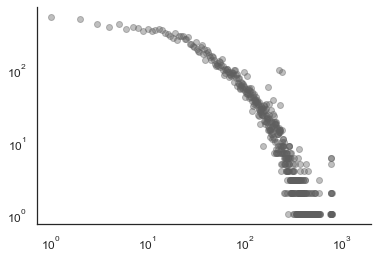

In [148]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

#Let's plot the Degree distribution of the EEN
fig1, ax1 = plt.subplots()
plt.scatter(degreesGGN, degreeDistributionGGNcount, c='#5F5F5F',marker='o', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000, 2000])

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)

#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
#plt.savefig('output/Figures/Fig1G.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1H

plt.show()
plt.close()

In [81]:
np.median(degrees_GGN)

36.0

In [96]:
backbone_ss_gene_network_degree_sort=dict(sorted(dict(nx.degree(backbone_ss_gene_network)).items(), key=lambda item: item[1], reverse=True))



In [97]:
top_10_gene=list(backbone_ss_gene_network_degree_sort.keys())[:10]
exp_top10=[]
for gene in top_10_gene:
    for chem in gene_chem_cleaned[gene]:
        exp_top10.append(chem)
    
exp_top10_dict_count=Counter(exp_top10).most_common()

In [100]:
top_10_gene

['ANKRD26P3',
 'CLEC17A',
 'CST11',
 'CTRC',
 'MROH2B',
 'MUC17',
 'KIAA1210',
 'MMP20',
 'MAPT-AS1',
 'LEF1-AS1']

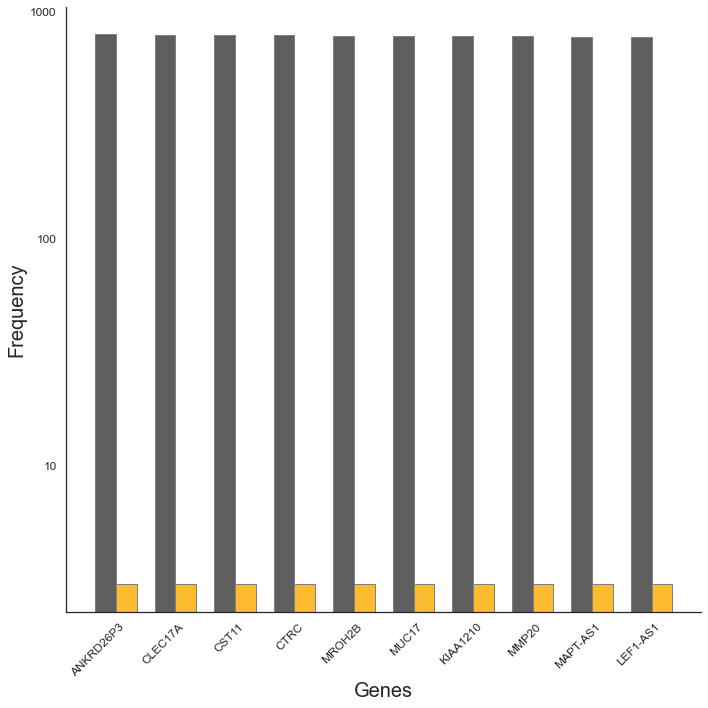

In [146]:

degree_list=[backbone_ss_gene_network_degree_sort[gene] for gene in top_10_gene]
exp_list=[len(gene_chem_cleaned[gene]) for gene in top_10_gene]

# define the width of bars
barWidth = 0.35 

fig1, ax1 = plt.subplots(figsize=(10, 10))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

r1 = np.arange(len(degree_list))    # position for degree bars
r2 = [x + barWidth for x in r1]  # position for gene bars

plt.bar(r1, degree_list, color='#5F5F5F', width=barWidth, edgecolor='grey')  # degree bars
plt.bar(r2, exp_list, color='#FDBB30', width=barWidth, edgecolor='grey')  # exp bars

# adding labels
ax1.set_xlabel('Genes', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
plt.xticks([r + barWidth for r in range(len(degree_list))], top_10_gene, rotation=45, ha='right', fontsize=12)
plt.yscale('log')
ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.yticks(fontsize=12)
#plt.savefig('output/Figures/Fig1H.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1I

plt.tight_layout()
plt.show()


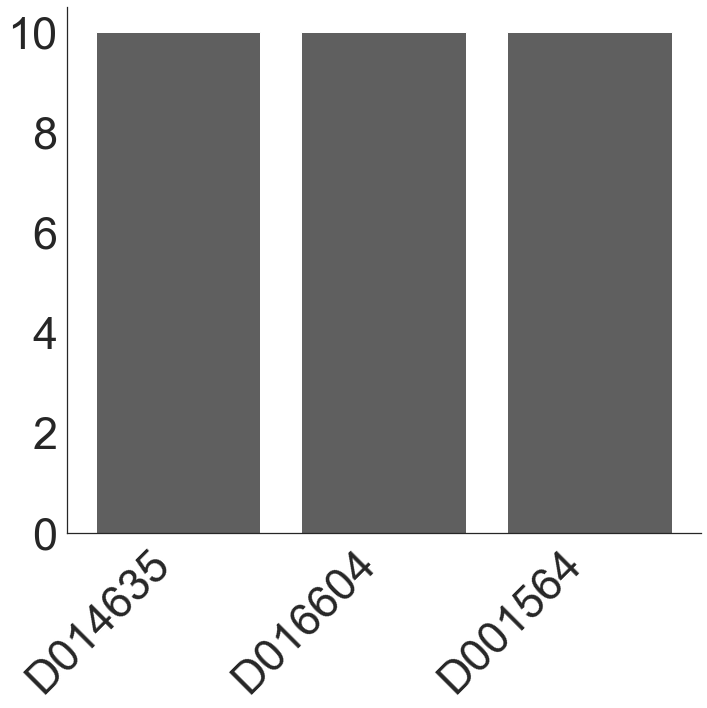

In [149]:
#Let's plot it, color them by their chemical class of belonging 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(figsize=(10, 10))

new_label=[g[0] for g in exp_top10_dict_count[:3]]
frequency=[g[1] for g in exp_top10_dict_count[:3]]


x = np.arange(3)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
plt.bar(x, frequency,color='#5F5F5F')
#plt.title('Frequency of exposures rank by their degree',fontsize=32)
#plt.ylabel('Frequency',fontsize=20)
#plt.xlabel('Exposures',fontsize=20)
#plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
#plt.yticks([],fontsize=45,rotation=45,ha='right')
plt.yticks(fontsize=45)
plt.tight_layout()

    
#plt.savefig('output/Figures/SF3B.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final SF2B
plt.show()

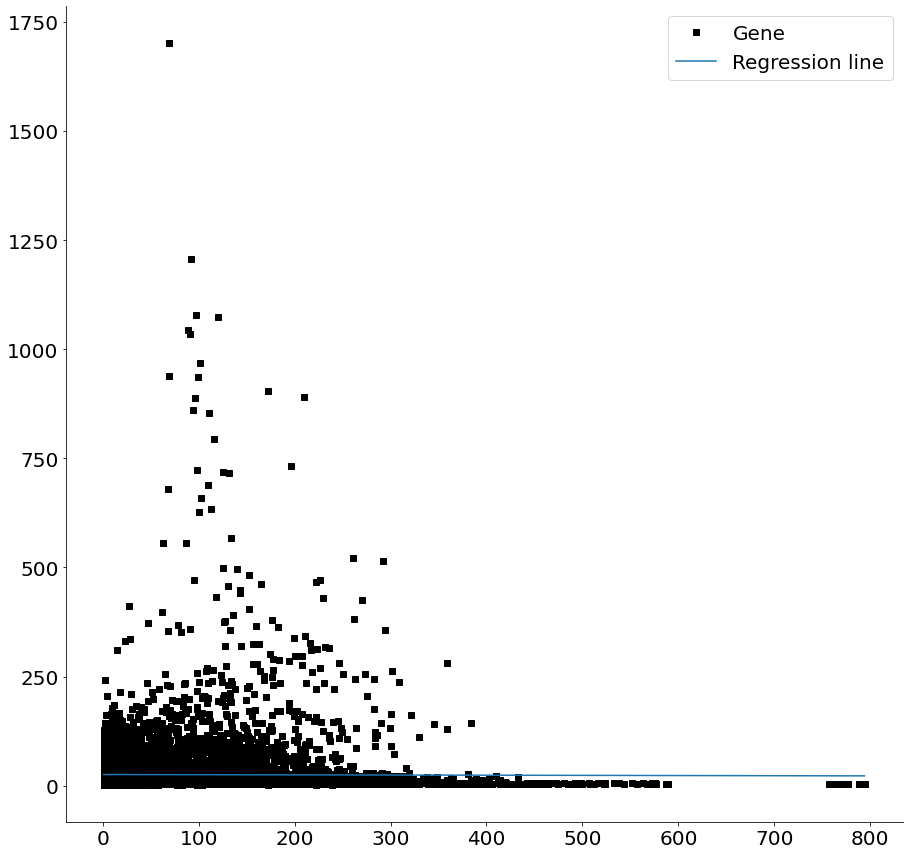

In [109]:
import scipy
from matplotlib.pyplot import figure
from scipy import stats

#Let's check whether there is a correlation between the number of perturbed genes and the number of connections in the EEN
deg_list=[]
len_chemlist=[]
for gene,deg in backbone_ss_gene_network_degree_sort.items():
    deg_list.append(deg)
    len_chemlist.append(len(gene_chem_cleaned[gene]))
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(deg_list, len_chemlist)

ax.plot(deg_list,len_chemlist, linewidth=0, marker='s',c='k', label='Gene')
y=[]
for i in deg_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(deg_list, y, label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 

# plt.title('Correlation between Resnik and Genetic overlap in %s' %met )
ax.legend(facecolor='white',fontsize=20)
plt.show()

In [111]:
print(scipy.stats.pearsonr(deg_list,len_chemlist))  # Pearson's r
print(scipy.stats.spearmanr(deg_list,len_chemlist)) # Spearman's rho

PearsonRResult(statistic=-0.00696773881490036, pvalue=0.2992015166510813)
SpearmanrResult(correlation=-0.19292842226872572, pvalue=3.9317007299462365e-185)


In [152]:
chem_list_1=[]
chem_list_2=[]
chem_list_3=[]
chem_list_4=[]
chem_list_5=[]
chem_list_6=[]
chem_list_7=[]
chem_list_8=[]
chem_list_9=[]
chem_list_10=[]

deg_max=max(list(backbone_ss_gene_network_degree_sort.values()))
for gene,deg in backbone_ss_gene_network_degree_sort.items():
    if deg<0.1*deg_max:
        chem_list_1.append(len(gene_chem_cleaned[gene]))
    elif deg>0.1*deg_max and deg<2*0.1*deg_max:
        chem_list_2.append(len(gene_chem_cleaned[gene]))
    elif deg>2*0.1*deg_max and deg<3*0.1*deg_max:
        chem_list_3.append(len(gene_chem_cleaned[gene]))
    elif deg>3*0.1*deg_max and deg<4*0.1*deg_max:
        chem_list_4.append(len(gene_chem_cleaned[gene]))
    elif deg>4*0.1*deg_max and deg<5*0.1*deg_max:
        chem_list_5.append(len(gene_chem_cleaned[gene]))
    elif deg>5*0.1*deg_max and deg<6*0.1*deg_max:
        chem_list_6.append(len(gene_chem_cleaned[gene]))
    elif deg>6*0.1*deg_max and deg<7*0.1*deg_max:
        chem_list_7.append(len(gene_chem_cleaned[gene]))
    elif deg>7*0.1*deg_max and deg<8*0.1*deg_max:
        chem_list_8.append(len(gene_chem_cleaned[gene]))
    elif deg>8*0.1*deg_max and deg<9*0.1*deg_max:
        chem_list_9.append(len(gene_chem_cleaned[gene]))
    else:
        chem_list_10.append(len(gene_chem_cleaned[gene]))
        

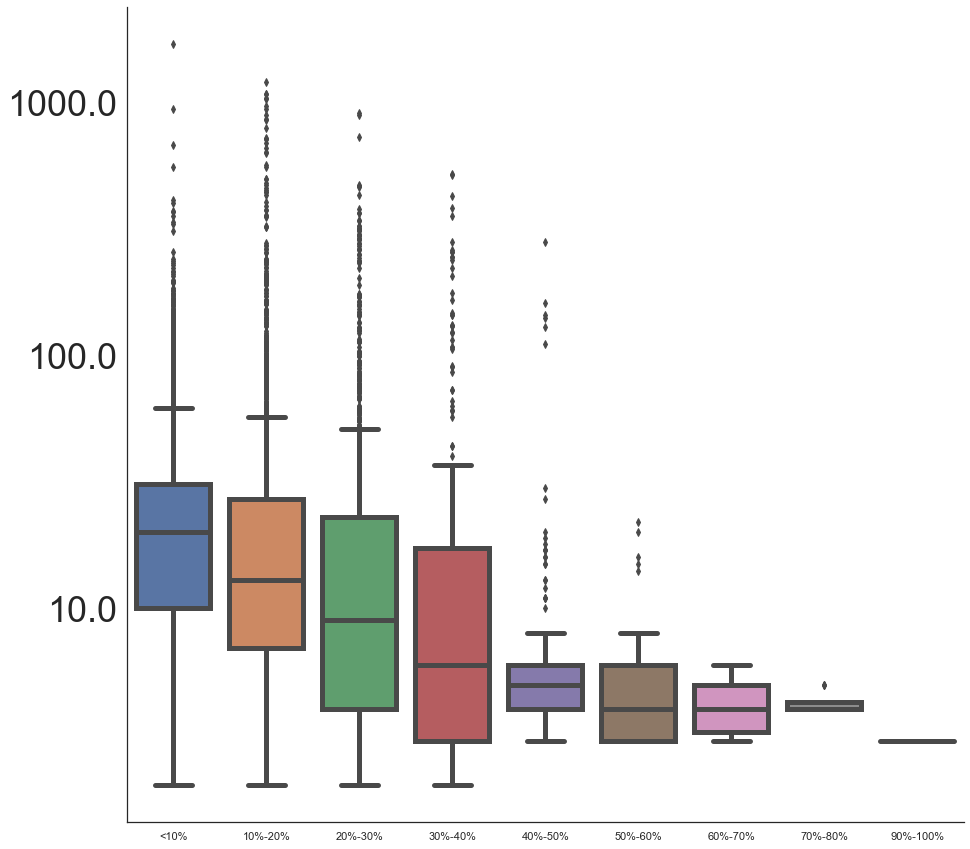

In [153]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community


column_names = ["Degree", "# Exposures"]

chem_list_tot=[]
group_list=[]
for i in chem_list_1:
    chem_list_tot.append(i)
    group_list.append("<10%")
    
for i in chem_list_2:
    chem_list_tot.append(i)
    group_list.append("10%-20%")

for i in chem_list_3:
    chem_list_tot.append(i)
    group_list.append("20%-30%")
    
for i in chem_list_4:
    chem_list_tot.append(i)
    group_list.append("30%-40%")
    
for i in chem_list_5:
    chem_list_tot.append(i)
    group_list.append("40%-50%")

for i in chem_list_6:
    chem_list_tot.append(i)
    group_list.append("50%-60%")

for i in chem_list_7:
    chem_list_tot.append(i)
    group_list.append("60%-70%")
    
for i in chem_list_8:
    chem_list_tot.append(i)
    group_list.append("70%-80%")
    
for i in chem_list_9:
    chem_list_tot.append(i)
    group_list.append("80%-90%")

for i in chem_list_10:
    chem_list_tot.append(i)
    group_list.append("90%-100%")
    
    
chem_degree_df = pd.DataFrame(columns = column_names)
chem_degree_df["# Exposures"]=chem_list_tot
chem_degree_df["Degree"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.boxplot(x=chem_degree_df["Degree"], y=chem_degree_df["# Exposures"], linewidth=5)
#ax = sns.barplot(x="louvain Iteration", y="z-score lcc", data=EEN_louvain_com_df,
#                 palette="Blues_d")
g.set_yscale("log")
#ax.set_xlabel("Louvain iteration",fontsize=32)
#ax.set_ylabel("lcc z-score enriched terms",fontsize=32)
ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
plt.savefig('output/Figures/SF2B.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()